In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as pl
import torch.nn.functional as F
import torchvision.models as models

In [2]:
from PIL import Image
from pathlib import Path
from lime import lime_image
from torchvision import transforms
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

/home/hope/Thesis/src/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from Models.CNN_model import CNN
from Models.VGG19_model import VGG19

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
cnn = CNN()
cnn.load_state_dict(torch.load('../assets/cnn_model.pth', map_location = device))
cnn.eval()

original_vgg19_model = models.vgg19(weights = 'VGG19_Weights.DEFAULT')
vgg = VGG19(original_vgg19_model)
vgg.load_state_dict(torch.load('../assets/vgg19_transfer.pth', map_location = device))
vgg.eval()

<All keys matched successfully>

In [6]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Normalize(mean = [0.1855, 0.1855, 0.1855], std = [0.2003, 0.2003, 0.2004])
])

preprocess_transform = transforms.ToTensor()

In [7]:
classes: dict[int, str] = { 0 : 'glioma', 
                            1 : 'meningioma', 
                            2 : 'notumor', 
                            3 : 'pituitary' }

In [8]:
def choose_random_image():
    image_path = list(Path('../assets/Dataset/Testing/').glob('*/*.jpg'))
    image_path = random.choice(image_path)
    image_class = image_path.parent.stem

    image = Image.open(image_path)
    image = image.convert('RGB')
    image = image.resize((224, 224))

    pl.rcParams.update({'font.size': 13})
    pl.figure(figsize = (6, 6))
    pl.imshow(image)
    pl.title(f'Orginal class = {image_class}')
    pl.axis('off')
    pl.show()

    return image

In [9]:
def get_model_prediction(model, image) -> int:
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.1855, 0.1855, 0.1855], std = [0.2003, 0.2003, 0.2004])
  ])

  input_tensor = transform(image)
  input_batch = input_tensor.unsqueeze(0)
  
  with torch.no_grad():
      output = model(input_batch)

  return torch.argmax(output[0]).item()

In [41]:
class Params:
  kernel_size = 2
  max_dist = 200
  ratio = 0.2
  num_samples = 200
  num_features = 30
  positive_only = False

params = Params()

In [14]:
def explain_with_lime(model, image_path: str, image_class: int, params: Params):
  image = Image.open(image_path)
  image = image.convert('RGB')
  image = image.resize((224, 224))
  print(f'Prediction = {classes[get_model_prediction(model, image)]}')
  image = np.array(image)

  def batch_predict(images: np.ndarray) -> np.ndarray:
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim = 0)

    batch  = batch.to(device)
    logits = model(batch)
    probs  = F.softmax(logits, dim = 1)

    return probs.detach().cpu().numpy()
  
  segmenter = SegmentationAlgorithm('quickshift', 
                                    kernel_size = params.kernel_size, 
                                    max_dist = params.max_dist, 
                                    ratio = params.ratio)
  
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(image = image,
                                           classifier_fn = batch_predict, 
                                           segmentation_fn = segmenter,
                                           num_samples = params.num_samples)
  
  print(f'Top label = {classes[explanation.top_labels[0]]}')
  
  temp, mask = explanation.get_image_and_mask(label = image_class,
                                              positive_only = params.positive_only, 
                                              num_features = params.num_features)
  
  marked_image = mark_boundaries(temp / 255.0, mask)

  pl.figure(figsize = (10, 10))
  pl.imshow(marked_image)
  pl.axis('off')

Prediction = meningioma


100%|██████████| 200/200 [00:34<00:00,  5.77it/s]


Top label = meningioma


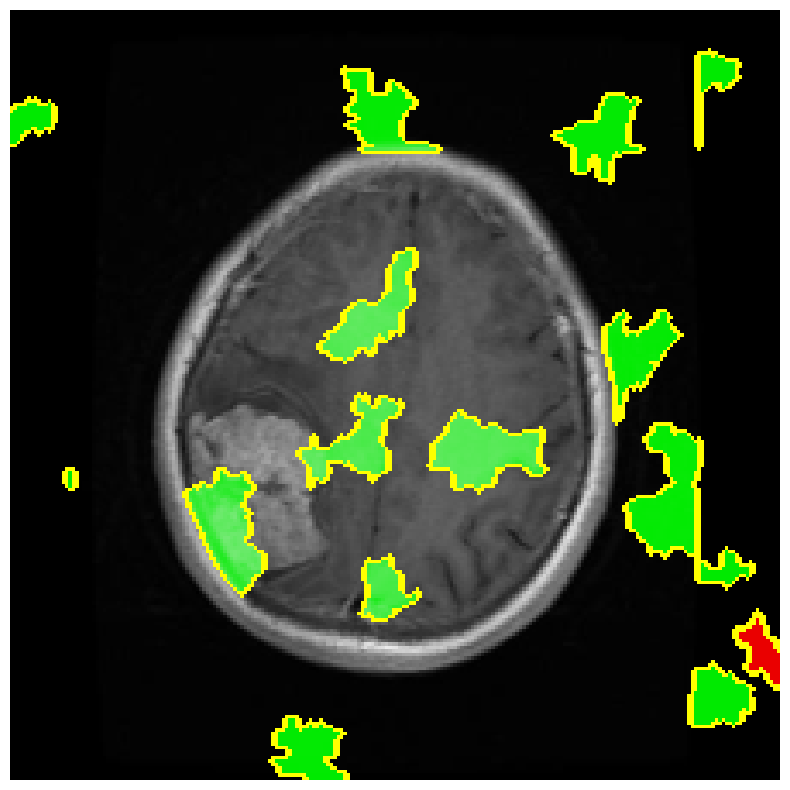

In [43]:
explain_with_lime(vgg, 'meningioma.jpg', 1, params)